# Imports

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import pandas as pd
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip

import pcshrink

# Data prep

Read in the human origins west eurasian data

In [2]:
%%time
data = pcshrink.UnpackedAncestryMap("/project/jnovembre/jhmarcus/ancient-sardinia/data/ref_genotypes/7-11-2018/lazaridis_2014/data_fil")

CPU times: user 7.18 s, sys: 2.23 s, total: 9.41 s
Wall time: 7.93 s


In [6]:
Y = data.Y
p, n = Y.shape
print(p, n)

594924 777


Find snps that are too rare or too common

In [7]:
# use allele frequency estimator from Price et al. 2006
f = (1. + np.nansum(Y, axis=1)) / (2 + (2. * n))

# keep snps that aren't too rare or common
snp_idx = np.where((f > .02) & (f < .98))[0]
print(f.shape, snp_idx.shape)

(594924,) (426765,)


Mean center and scale and impute missing values to 0

In [8]:
Z = Y[snp_idx, :]

# mean genotype 
mu = np.nanmean(Z, axis=1).reshape(len(snp_idx), 1)

# empirical std deviation
std = np.nanstd(Z, axis=1).reshape(len(snp_idx), 1)

# heterozygosity scaler
het = np.sqrt(2. * f[snp_idx] * (1. - f[snp_idx])).reshape(len(snp_idx), 1)

Z = (Z - mu) / het
Z[np.isnan(Z)] = 0.0

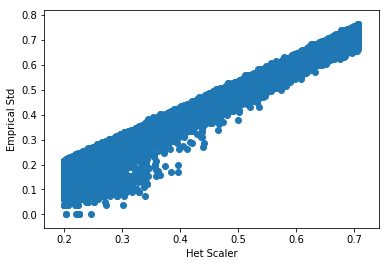

In [9]:
plt.scatter(het, std);
plt.xlabel("Het Scaler");
plt.ylabel("Emprical Std");

# PCA

In [270]:
%%time
k = 5
Y = Z

U, S, VT = svds(Y, k)

# singular values
S = np.diag(S[::-1])

# left and right eigenvectors
U, VT = svd_flip(U[:, ::-1], VT[::-1])
V = VT.T

CPU times: user 34.2 s, sys: 3.07 s, total: 37.3 s
Wall time: 1.38 s


In [224]:
%%time


CPU times: user 33 ms, sys: 46.8 ms, total: 79.7 ms
Wall time: 78.2 ms


In [225]:
print(U.shape)
print(a.shape)

(426765, 5)
(426765, 1)


In [265]:
%%time

# snp by individual SVD
p, n = Y.shape
a = -Y[:, n-1].reshape(p, 1)
b = np.zeros(n).reshape(n, 1)
b[j-1] = 1

m = U.T @ a
p = a - (U @ m)
R_a = np.sqrt(p.T @ p)
P = (1. / R_a) * p

##################

n = V.T @ b
q = b - (V @ n)
R_b = np.sqrt(q.T @ q)
Q = (1 / R_b) * q

K_0 = np.zeros((S.shape[0] + 1, S.shape[0] + 1))
K_0[:-1, :-1] = S
K_1 = np.append(m, R_a).reshape(-1, 1) @ np.append(n, R_b).reshape(1, -1)
K = K_0 + K_1

tUp, tSp, tVpT = svds(K, k)
tUp, tVpT = svd_flip(tUp[:, ::-1], tVpT[::-1])
tVp = tVpT.T

Up = np.hstack([U, P]) @ tUp
Sp = np.diag(tSp)
Vp = np.hstack([V, Q]) @ tVp

CPU times: user 579 ms, sys: 25.3 ms, total: 605 ms
Wall time: 35.9 ms


In [266]:
F = Up @ Sp
F = F / np.linalg.norm(F, axis=0, ord=2)
F.shape

(426765, 5)

In [271]:
%%time 
L = (F.T @ Y).T
L.shape

CPU times: user 6.36 s, sys: 1.23 s, total: 7.59 s
Wall time: 1.59 s


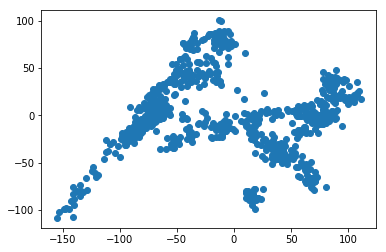

In [254]:
plt.scatter(L[:,0], -L[:,1])

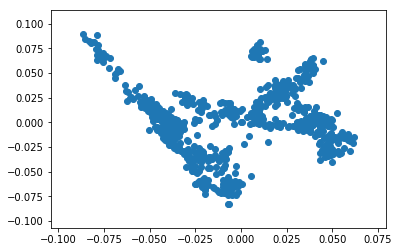

In [275]:
plt.scatter(Vp[:,0], Vp[:, 1])

In [277]:
tVp.shape

(6, 5)